In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from astropy import constants as csts


**Scalar Form**:

Newton's Law of Gravitation gives the *magnitude* of the force between two point masses:

$ F = G \frac{m_{1}m_{2}}{r^{2}} $

but does not consider direction. We need this for simulation.

**Vector Form**:
Must consider direction from one vector to another.

Let:


- $ \vec{r_{i}} $ be position of object $i$

-  $ \vec{r_{ij}} $ is vector pointing from $i$ to $j$

- Its magnitude is $r =$ |$\vec{r_{ij}}$|

The unit vector in that direction is: 

$ \hat{r}_{ij} = \frac{\vec{r_{ij}}}{|\vec{r_{ij}}|} $

Consider 3 bodies interacting in a 3-body system. The force vector between any two of these bodies is as follows:

$ \vec{F_{12}} = G\frac{m_{1}m_{2}}{r_{12}^{2}}\hat{r}_{12} = G\frac{m_{1}m_{2}}{r_{12}^{2}}*\frac{\vec{r}_{12}}{|\vec{r_{12}}|} =  G\frac{m_{1}m_{2}}{r_{12}^{2}}*\frac{\vec{r}_{12}}{r_{12}} = G\frac{m_{1}m_{2}}{r_{12}^{3}} \vec{r}_{12} $


Given $ N $ bodies interacting, the overall force vector acting on a given body, $ i $ is as follows:

$ \vec{F_{i}} = G m_{i} \sum_{j\neq{i}}^{N} m_{j} \frac{\vec{r}_{ij}}{|r_{ij}|^{3}} $

and the vector acceleration:

$ \vec{a_{i}} = G  \sum_{j\neq{i}}^{N} m_{j} \frac{\vec{r}_{ij}}{|r_{ij}|^{3}} $

-------------------------------

Note that a 'softening factor' is added to the calculation to avoid potential division by zero.

**Numerical Methods**
Since the N-body problem has no exact, analytical solution for N>2, numerical methods must be used.

**Euler Method**:
Simplest method https://www.freecodecamp.org/news/eulers-method-explained-with-examples/

$ a_{i} = \frac{F_{i}}{m_{i}} $

$ x_{i+1} = x_{i} + v_{i}\Delta{t} $

$ v_{i+1} = v_{i} + a_{i}\Delta{t} $


**Euler-Cromer Method**:
Simple modification to the Euler method that bounds the energy error over time (see later), which is good for long time-scale simulations.
For this, we update the position using the updated velocity, $ v_{i+1} $, as opposed to  $ v_{i} $. I.e.

$ v_{i+1} = v_{i} + a_{i}\Delta{t} $

$ x_{i+1} = x_{i} + v_{i+1}\Delta{t} $

**Velocity Verlet**:

The Euler and Euler-Cromer methods fix the acceleration as constant over the entire time step, equal to its value at the beginning of said time interval. The Velocity Verlet algorithm improves upon this by introducing the evaluation of the acceleration 'in the middle' of the time interval, and updating the position and velocities using this, increasing accuracy.

The position formula comes from the (second-order) Taylor expansion of the position.

$ x_{i+1} = x_{i} + v_{i}\Delta{t} + \frac{1}{2}a_{i}\Delta{t} $

Then calculate $ a_{i+1} $ in order to work out 'average' acceleration over time step.

$ a_{i+1} = \frac{F(r_{i+1})}{m} $

Update velocity based on average acceleration:

$ v_{i+1} = v_{i} + \frac{1}{2}[a_{i} + a_{i+1}]\Delta{t} $

In [ ]:
class System:
    def __init__(self, num_objects: int, x: np.ndarray, v: np.ndarray, m: np.ndarray, G: float, softening: float) -> None:
        self.num_objects = num_objects
        self.x = x
        self.v = v
        self.m = m
        self.G = G
        self.softening = softening # to avoid dividing by zero
        
    # NESTED FOR LOOPS -- once working implement better algorithm.
        
    def compute_forces(self) -> np.ndarray:
        forces = np.zeros_like(self.x)
        for i in range(self.num_objects):
            for j in range(self.num_objects):
                if i != j:
                    r_ij = self.x[j] - self.x[i]
                    dist_squared = np.dot(r_ij, r_ij) + self.softening**2
                    dist_cubed = dist_squared ** 1.5
                    force_ij = self.G * self.m[i] * self.m[j] * (r_ij/(dist_cubed))
                    forces[i] += force_ij
        return forces
    
    # Energy Error Tracker:
# function that runs at each time step in simulation to track total energy.

#might be able to combine this with compute_forces since its doing same calcs?? 

    def energy_error(self):
        KE = 0.0
        PE = 0.0
        for i in range(self.num_objects):
            KE += 0.5 * self.m[i] * (np.linalg.norm(self.v[i]))**2
            for j in range(i+1, self.num_objects):
                r_ij = self.x[j] - self.x[i]
                dist = np.linalg.norm(r_ij)**2 + self.softening**2
                dist = np.sqrt(dist)
                PE -= self.G * self.m[i] * self.m[j]/dist
        total_energy = KE + PE
        return KE, PE, total_energy
            

    
    # First test - Euler Method: Simplest way to approximate solution.    
    def update_params_euler(self, dt:float) -> None:
        forces = self.compute_forces()
        accs = forces/self.m[:,np.newaxis]
        # changing shape of mass array such that shapes compute for division
        
        # Updating velocity and position
        self.x += self.v * dt
        self.v += accs * dt
                
    def simulation_euler(self, n_steps: int, dt: float) -> tuple:
        trajectory = [self.x.copy()]
        KE_track = []
        PE_track = []
        TE_track = []
        
        for i in range(n_steps):
            self.update_params_euler(dt)
            # this computes forces and updates parameters
            trajectory.append(self.x.copy())

            KE, PE, total_energy = self.energy_error()
            KE_track.append(KE)
            PE_track.append(PE)
            TE_track.append(total_energy)

        return trajectory, KE_track, PE_track, TE_track
    
    
    # Euler-Cromer Method
    
    def update_params_euler_cromer(self, dt:float) -> None:
        forces = self.compute_forces()
        accs = forces/self.m[:,np.newaxis]
        
        self.v += accs * dt
        self.x += self.v * dt
        
    def simulation_euler_cromer(self, n_steps: int, dt: float) -> tuple:
        trajectory = [self.x.copy()]
        KE_track = []
        PE_track = []
        TE_track = []
        
        for i in range(n_steps):
            self.update_params_euler_cromer(dt)
            # this computes forces and updates parameters
            trajectory.append(self.x.copy())

            KE, PE, total_energy = self.energy_error()
            KE_track.append(KE)
            PE_track.append(PE)
            TE_track.append(total_energy)

        return trajectory, KE_track, PE_track, TE_track
        
    def update_params_velocity_verlet(self, dt:float) -> None:
        forces = self.compute_forces()
        accs = forces/self.m[:,np.newaxis]

**Relative Energy Error**:

Since our approximate methods are not fully accurate, it is handy to assess the accuracy of system given a particular numerical method. To do this we can use the relative energy error. In theory, due to conservation of energy, the total energy remains constant, but in practice with these methods, that is not the case. A more accurate method will better conserve the total energy of the system thus we have a measure of accuracy. Note the limits of the P.E sum to avoid double-counting potentials.

$ \text{Total Energy = Total Kinetic E - Total Potential E} $
        
$ \text{Total Energy} =  \sum_{i=1}^{N} \frac{1}{2}m_{i}v_{i}^{2} - \sum_{i=1}^{N} \sum_{j>i}^{N} \frac{G m_{i} m_{j}}{r_{ij}}$ 

By tracking this quantity over course of simulation we can assess the accuracy of the numerical method used.

The 'Relative Energy Error' is a more helpful quantity to plot as it can highlight small drifts in total energy and is useful for comparing simulations with different energies.

$ \text{Relative Energy Error} = \frac{|\text{Energy}-\text{Initial Energy}|}{\text{Initial Energy}} $



In [3]:
# # 2 body check:
# G = 1
# num_objects = 2

# initial_positions = np.array([[1, 0, 0], [-1, 0, 0]], dtype=float)
# masses = np.array([1.0, 1.0])
# v_circ = np.sqrt(G * masses[1] / 2.0)
# initial_velocities = np.array([[0, -v_circ, 0], [0, v_circ, 0]])

# system = System(num_objects = num_objects, x=initial_positions, v=initial_velocities, m=masses, G=G, softening=1e-5)
# trajectory = system.simulation(n_steps =1000, dt=0.01)
# trajectory = np.array(trajectory)

# for i in range(num_objects):
#     plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], label=f'Body {i+1}')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Trajectories of N Bodies')
# plt.axis('equal')
# plt.legend()
# plt.show()

# 2-body simulations - testing

## Testing Euler (with energy tracking)

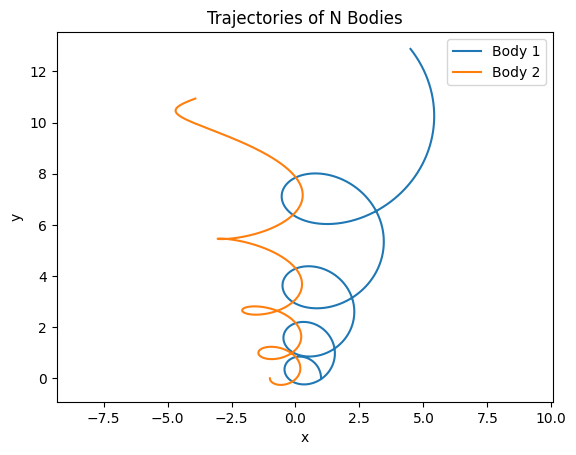

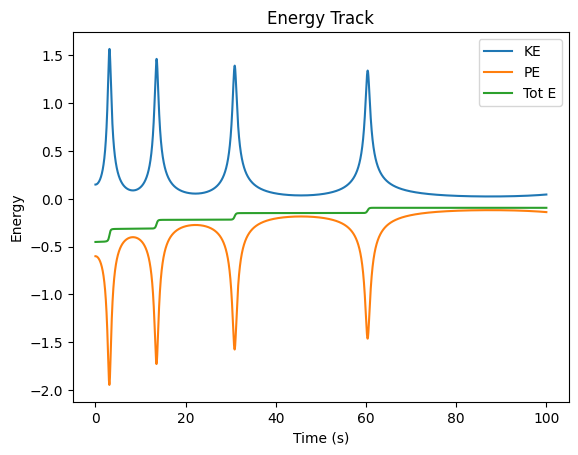

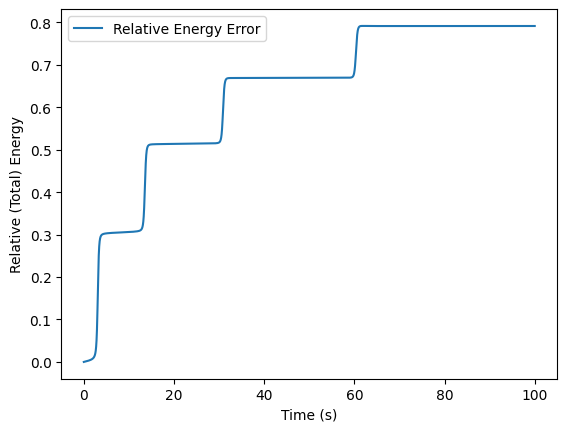

In [ ]:
# 2 body to test
%matplotlib inline
G = 1 # since we are using masses, positions of order 1, use natural units
num_objects = 2
initial_positions = np.array([[1, 0, 0], [-1, 0, 0]], dtype=float)
initial_velocities = np.array([[0, 0.5, 0], [0, -0.2, 0]], dtype=float)
masses = np.array([1.0, 1.2])
dt = 0.01
n_steps = 10000

system = System(num_objects = num_objects, x=initial_positions, v=initial_velocities, m=masses, G=G, softening=1e-5)
trajectory, KE_track, PE_track, TE_track = system.simulation_euler(n_steps = n_steps , dt=dt)
trajectory = np.array(trajectory)

plt.figure()
for i in range(num_objects):
    plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], label=f'Body {i+1}')
    # trajectory is array with [time steps, index of body, spatial dimension]
    # so plotting all time steps for given body in x, then y
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of N Bodies')
plt.axis('equal')
plt.legend()
plt.show()

# Absolute Energy Tracking:
time_steps = np.arange(len(KE_track)) * dt # Gets a time axis
plt.figure()
plt.plot(time_steps, KE_track, label='KE')
plt.plot(time_steps, PE_track, label='PE')
plt.plot(time_steps, TE_track, label='Tot E')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Energy Track')
plt.legend()
plt.show()

# Relative Energy Tracking:
plt.figure()
initial_energy = TE_track[0]
relative_error = (abs(TE_track - initial_energy))/abs(initial_energy)
plt.plot(time_steps, relative_error, label='Relative Energy Error')
plt.xlabel('Time (s)')
plt.ylabel('Relative (Total) Energy')
plt.legend()
plt.show()

Despite a simple 2-body case, the inaccurate Euler integration causes orbits to diverge after a few periods. The energy error is also unbounded and is relatively large. Note the spikes in KE/PE are due to close approach of the bodies.

## Testing Euler-Cromer

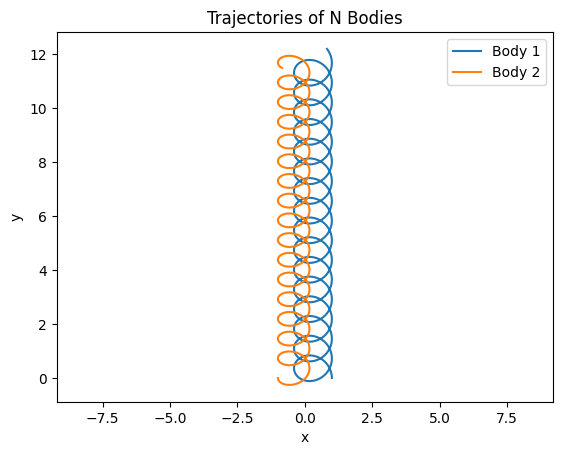

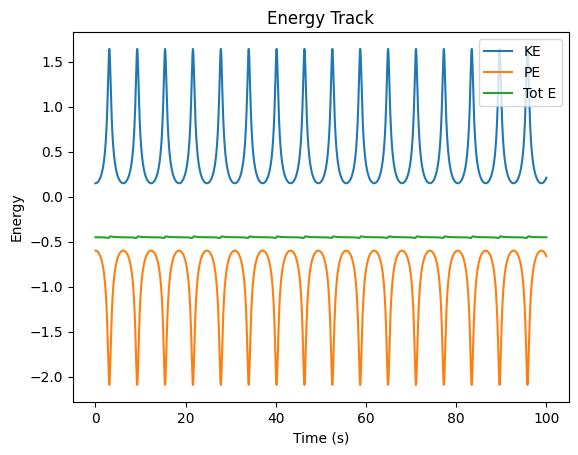

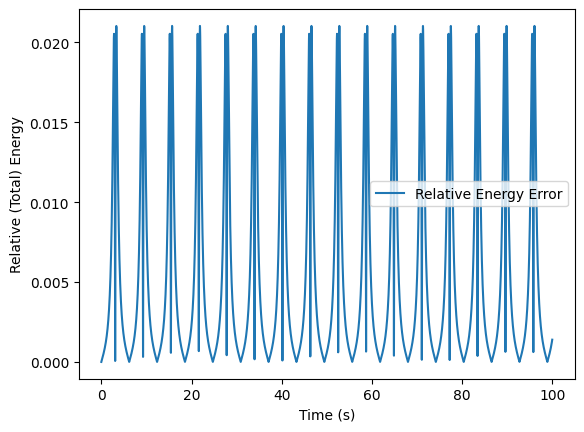

In [10]:
# 2 body to test EULER-CROMER   
%matplotlib inline
G = 1 # since we are using masses, positions of order 1, use natural units
num_objects = 2
initial_positions = np.array([[1, 0, 0], [-1, 0, 0]], dtype=float)
initial_velocities = np.array([[0, 0.5, 0], [0, -0.2, 0]], dtype=float)
masses = np.array([1.0, 1.2])
dt = 0.01
n_steps = 10000

system = System(num_objects = num_objects, x=initial_positions, v=initial_velocities, m=masses, G=G, softening=1e-5)
trajectory, KE_track, PE_track, TE_track = system.simulation_euler_cromer(n_steps = n_steps, dt=dt)
trajectory = np.array(trajectory)

plt.figure()
for i in range(num_objects):
    plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], label=f'Body {i+1}')
    # trajectory is array with [time steps, index of body, spatial dimension]
    # so plotting all time steps for given body in x, then y
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of N Bodies')
plt.axis('equal')
plt.legend()
plt.show()

# Energy Tracking:
time_steps = np.arange(len(KE_track)) * dt # Gets a time axis
plt.figure()
plt.plot(time_steps, KE_track, label='KE')
plt.plot(time_steps, PE_track, label='PE')
plt.plot(time_steps, TE_track, label='Tot E')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Energy Track')
plt.legend()
plt.show()

# Relative Energy Tracking:
plt.figure()
initial_energy = TE_track[0]
relative_error = (abs(TE_track - initial_energy))/abs(initial_energy)
plt.plot(time_steps, relative_error, label='Relative Energy Error')
plt.xlabel('Time (s)')
plt.ylabel('Relative (Total) Energy')
plt.legend()
plt.show()

With the same initial conditions as the Euler case, the Euler-Cromer algorithm is seen to be much more stable and orbits stay bounded. The relative energy is also bounded and an order of magnitude better than Euler.

## Velocity-Verlet Algorithm

With this, if I simulate a 2 body orbit I should be able to achieve a fairly stable orbit.

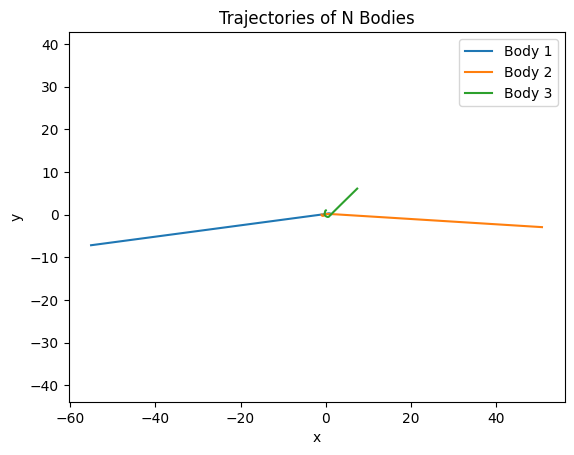

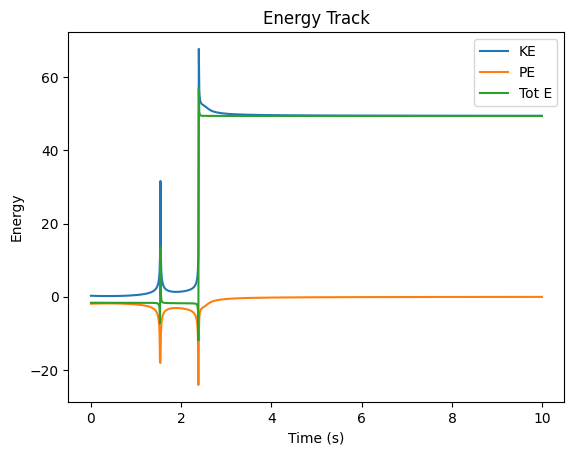

In [25]:
# 3 body

G = 1 # since we are using masses, positions of order 1, use natural units
num_objects = 3
initial_positions = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0]], dtype=float)
initial_velocities = np.array([[0.5, 0, 0], [0, -0.5, 0], [-0.2, 0, 0]], dtype=float)
masses = np.array([1, 1.0, 1])
n_steps = 1000
dt = 0.01

system = System(num_objects = num_objects, x=initial_positions, v=initial_velocities, m=masses, G=G, softening=1e-5)
trajectory, KE_track, PE_track, TE_track = system.simulation_euler_cromer(n_steps = n_steps, dt= dt)
trajectory = np.array(trajectory)

plt.figure()
for i in range(num_objects):
    plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], label=f'Body {i+1}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of N Bodies')
plt.axis('equal')
plt.legend()
plt.show()

# Energy Tracking:
time_steps = np.arange(len(KE_track)) * dt # Gets a time axis
plt.figure()
plt.plot(time_steps, KE_track, label='KE')
plt.plot(time_steps, PE_track, label='PE')
plt.plot(time_steps, TE_track, label='Tot E')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Energy Track')
plt.legend()
plt.show()

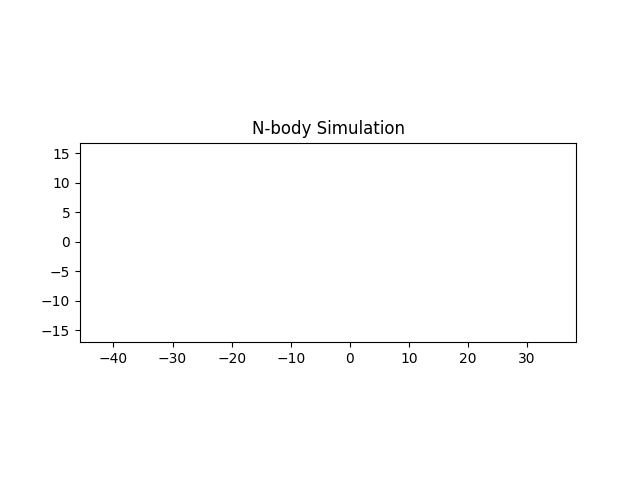

In [14]:
%matplotlib widget
# Assume `trajectory` is already computed and is shape (n_steps, N, 3)
n_steps, N, _ = trajectory.shape

# Set up the figure and axes
fig, ax = plt.subplots()
ax.set_xlim(np.min(trajectory[:,:,0]) - 1, np.max(trajectory[:,:,0]) + 1)
ax.set_ylim(np.min(trajectory[:,:,1]) - 1, np.max(trajectory[:,:,1]) + 1)
ax.set_aspect('equal')
ax.set_title('N-body Simulation')

# Initialize scatter plot
scat = ax.scatter([], [], s=50)

# Optional: add trails
trails = [ax.plot([], [], lw=1)[0] for _ in range(N)]

# Update function
def update(frame):
    x = trajectory[frame, :, 0]
    y = trajectory[frame, :, 1]
    scat.set_offsets(np.column_stack((x, y)))
    
    # Update trails
    for i in range(N):
        trails[i].set_data(trajectory[:frame+1, i, 0], trajectory[:frame+1, i, 1])
    return scat, *trails

# Create animation
ani = FuncAnimation(fig, update, frames=n_steps, interval=10, blit=True)

plt.show()

In [ ]:
# For later 
# def CoM_correction(self) -> None:
#         #Setting CoM of position and velocity to zero to prevent net motion of system during simulation.
#         x_com = np.zeros(3)
#         v_com = np.zeros(3)
#         M = 0.0
#         for i in range(self.num_objects):
#             x_com += self.m[i]*self.x[i]
#             v_com += self.m[i]*self.v[i]
#             M += self.m[i]
        
#         x_com /= M
#         v_com /= M
#         self.x -= x_com
#         self.v -= v_com
        
    